In [1]:
import os
import copy
import time
import pickle
import sys

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sian.utils import gettimestamp
from sian.data import Final_TabularDataset
from sian.models import TrainingArgs

from sian.fis import layerwise_FIS_Hyperparameters, batchwise_FIS_Hyperparameters
from sian.interpret import unmasked_FID_Hyperparameters, masked_FID_Hyperparameters
from sian import initalize_the_explainer

from sian import train_mlp_final, do_the_fis_final, train_sian_final #steps 1, 2, and 3
from sian.interpret import plot_all_GAM_functions #step 4


%load_ext autoreload
%autoreload 2

In [2]:
BS = 32
# EP = 100
EP = 10
LR = 5e-3

if False:
    dataset_str = "UCI_275_bike_sharing_dataset"
    preproc_owner = "SIAN2022"
if True:
    dataset_str = "UCI_186_wine_quality"
    preproc_owner = "SIAN2022"
if False:
    dataset_str = "UCI_2_adults_dataset"
    preproc_owner = "InstaSHAP2025"
if False:
    dataset_str = "UCI_31_tree_cover_type_dataset"
    preproc_owner = "InstaSHAP2025"


data_base_path = "../data/"
load_dataset_path = data_base_path
save_dataset_path = data_base_path+dataset_str+"/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_training_args = TrainingArgs(BS, EP, LR, device)
sian_training_args = TrainingArgs(BS, EP, LR, device)




is_masked_mlp = True;  is_masked_sian = True;
# is_masked_mlp = False; is_masked_sian = False;

FIS_style = 'batchwise'
# FIS_style = 'layerwise'    

MAX_K = None
MAX_K = 3
MAX_K = 2 


In [3]:

results_path = "results/"
exp_datetimestr = gettimestamp()
exp_folder = results_path+exp_datetimestr +'_'+ "demo" +'_simple_testing/'
if not os.path.exists(exp_folder):
    os.makedirs(exp_folder)
print(exp_folder)

results/20250428_192230_demo_simple_testing/


In [4]:

if True: #DEFAULT MODEL PARAMETRIZATION
    mlp_training_args.model_config.net_name = "MLP"
    mlp_training_args.model_config.sizes = [-1, 256, 128, 64, -1]
    mlp_training_args.model_config.is_masked = is_masked_mlp
    mlp_training_args.saving_settings.exp_folder = exp_folder
    
    sian_training_args.model_config.net_name = "SIAN-K"
    sian_training_args.model_config.sizes = [-1, 256, 128, 64, -1]
    sian_training_args.model_config.small_sizes = [-1, 32, 24, 16, -1]
    sian_training_args.model_config.is_masked = is_masked_sian
    sian_training_args.saving_settings.exp_folder = exp_folder

In [5]:
dataset_obj = \
    Final_TabularDataset(dataset_str, preproc_owner=preproc_owner,
                       load_dataset_path=load_dataset_path, 
                       save_dataset_path=save_dataset_path)     


header_dict None
PROCESSING AND LOADING


In [6]:
D = dataset_obj.get_D()
readable_labels = dataset_obj.get_readable_labels()
print(readable_labels)

{0: 'fixed acidity', 1: 'volatile acidity', 2: 'citric acid', 3: 'residual sugar', 4: 'chlorides', 5: 'free sulfur dioxide', 6: 'total sulfur dioxide', 7: 'density', 8: 'pH', 9: 'sulphates', 10: 'alcohol', 11: 'color'}


# SIAN Step 1: Train Masked MLP

In [7]:
mlp_results = train_mlp_final(dataset_obj, mlp_training_args)
trained_mlp = mlp_results["trained_mlp"]
val_tensor = mlp_results["val_tensor"]


trnval_shuffle_seed 0
self.trnval_shuffle_seed 0
trnX trnY (3637, 13) (3637, 1)
Epoch 0
MSE for train and val: 2.850069126274745, 2.7073694701095996
--- 0.556 seconds in epoch ---
Epoch 1
MSE for train and val: 1.2630776870721037, 1.204481664007093
--- 0.514 seconds in epoch ---
Epoch 2
MSE for train and val: 1.766827936670484, 1.7308561813399739
--- 0.506 seconds in epoch ---
Epoch 3
MSE for train and val: 0.8032882830912966, 0.7737545858729995
--- 0.461 seconds in epoch ---
Epoch 4
MSE for train and val: 0.6599293622911132, 0.6412178917174766
--- 0.467 seconds in epoch ---
Epoch 5
MSE for train and val: 0.7227338851414046, 0.7225556954549065
--- 0.468 seconds in epoch ---
Epoch 6
MSE for train and val: 0.6304034748913742, 0.6282564814614972
--- 0.546 seconds in epoch ---
Epoch 7
MSE for train and val: 0.6125681718415322, 0.6085356711207979
--- 0.476 seconds in epoch ---
Epoch 8
MSE for train and val: 0.5764114871133447, 0.5726431628910537
--- 0.512 seconds in epoch ---
Epoch 9
MSE fo

# SIAN Step 2: Masked Archipelago FIS

### setup FID hypers

In [8]:

output_type = "regression"  #TODO: can set to classification when masking version has support (not sobol version)
grouped_features_dict = dataset_obj.get_grouped_feature_dict()
if is_masked_mlp: 
    fid_masking_style = "masking_based"
    score_type_name = "new_arch_inter_sobol_score"
    inc_rem_pel_list = ['inc_inter_sobol_score', 'rem_inter_sobol_score', 'new_arch_inter_sobol_score',] #NOTE: only for batchwise plots
    fis_valX = val_tensor

    my_FID_hypers = masked_FID_Hyperparameters(fid_masking_style, output_type, score_type_name, inc_rem_pel_list,
                                               grouped_features_dict)
else:    
    fid_masking_style = "triangle_marginal"
    score_type_name = "old_arch_inter_score"
    inc_rem_pel_list = ['inc_inter_score', 'rem_inter_score', 'old_arch_inter_score',] #NOTE: only for batchwise plots
    fis_valX = val_tensor.detach().cpu().numpy()
    
    my_FID_hypers = unmasked_FID_Hyperparameters(fid_masking_style, output_type, score_type_name, inc_rem_pel_list,
                                               device, grouped_features_dict)


### setup FIS hypers

In [9]:

if FIS_style=="batchwise":
    max_number_of_rounds = 5
    inters_per_round = 1
    tau_tup=(1.0,0.5,0.33)
    
    tau_thresholds = {}
    for k in range(MAX_K): #NOTE: no good MAX_K = None support yet
        tau_thresholds[k+1] = tau_tup[k]
    
    my_FIS_hypers = batchwise_FIS_Hyperparameters(MAX_K, tau_thresholds, max_number_of_rounds, inters_per_round,
                   # jam_arch, 
                   None, 
                   tuples_initialization=None,pick_underlings=False,fill_underlings=False,PLOTTING=True)

elif FIS_style=="layerwise":

    theta_percentile_mode=True
    theta_tup=(0.8,0.4,0.2)
    tau_tup=(1.0,0.5,0.33)
    
    tau_thresholds, theta_thresholds = {}, {}
    for k in range(MAX_K):
        tau_thresholds[k+1] = tau_tup[k]
        theta_thresholds[k+1] = theta_tup[k]

    my_FIS_hypers = layerwise_FIS_Hyperparameters(MAX_K, tau_thresholds, theta_thresholds, 
                   # jam_arch, 
                   None, 
                   theta_percentile_mode=theta_percentile_mode)
else:
    raise Exception(f"FIS_style={FIS_style} not recognized")


### finalize the FID and FIS hypers

In [10]:
jam_arch = initalize_the_explainer(trained_mlp, my_FID_hypers)
my_FIS_hypers.add_the_explainer(jam_arch)

### run the actual FIS

nr 0
archipelago_tensor (12, 2, 1560)
semitruth torch.Size([1560, 1])


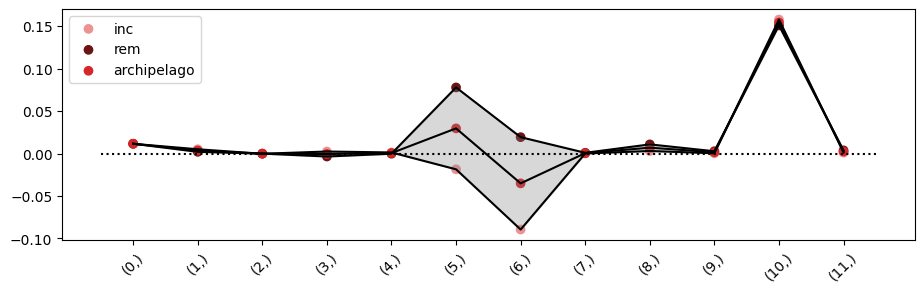

new_selections [(10,)]
selections [(10,)]
new_cands []
candidates [(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (11,)]
0.39040446281433105 seconds
nr 1
archipelago_tensor (11, 2, 1560)
semitruth torch.Size([1560, 1])


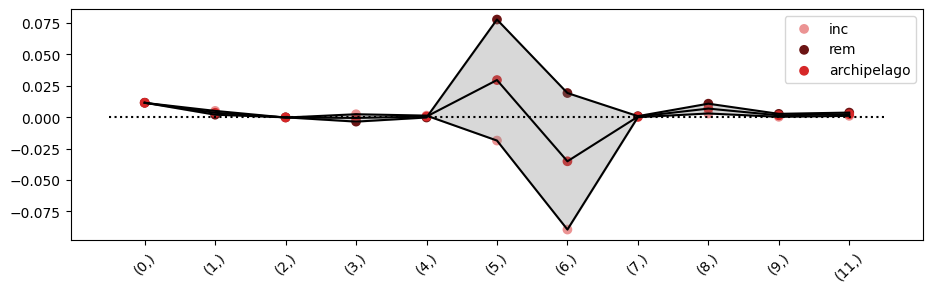

new_selections [(5,)]
selections [(10,), (5,)]
new_cands [(5, 10)]
candidates [(0,), (1,), (2,), (3,), (4,), (6,), (7,), (8,), (9,), (11,), (5, 10)]
0.7104907035827637 seconds
nr 2
archipelago_tensor (11, 2, 1560)
semitruth torch.Size([1560, 1])


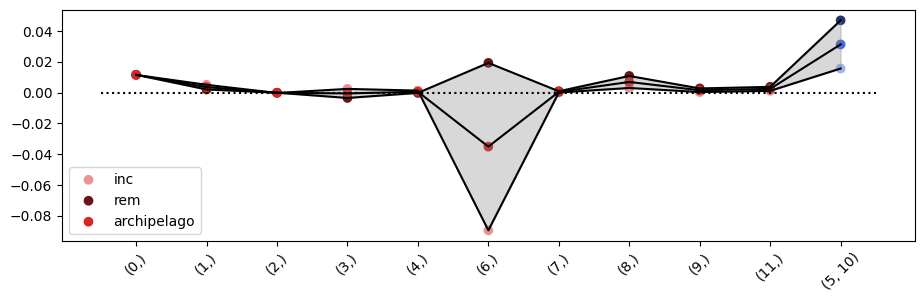

new_selections [(5, 10)]
selections [(10,), (5,), (5, 10)]
new_cands [(5, 10)]
candidates [(0,), (1,), (2,), (3,), (4,), (6,), (7,), (8,), (9,), (11,)]
1.0587077140808105 seconds
nr 3
archipelago_tensor (10, 2, 1560)
semitruth torch.Size([1560, 1])


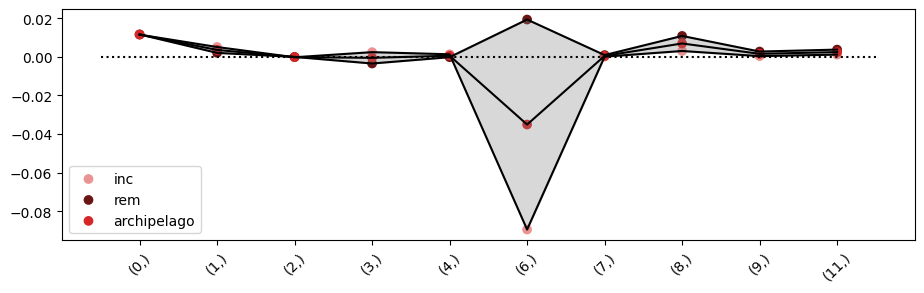

new_selections [(0,)]
selections [(10,), (5,), (5, 10), (0,)]
new_cands [(5, 10), (0, 10), (0, 5)]
candidates [(1,), (2,), (3,), (4,), (6,), (7,), (8,), (9,), (11,), (0, 10), (0, 5)]
1.4453847408294678 seconds
nr 4
archipelago_tensor (11, 2, 1560)
semitruth torch.Size([1560, 1])


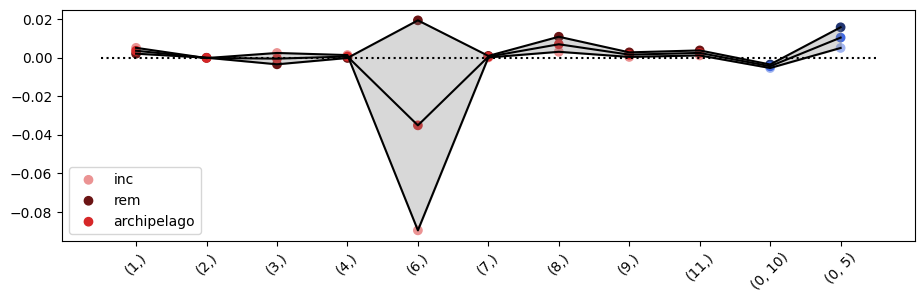

new_selections [(0, 5)]
selections [(10,), (5,), (5, 10), (0,), (0, 5)]
new_cands [(5, 10), (0, 10), (0, 5)]
candidates [(1,), (2,), (3,), (4,), (6,), (7,), (8,), (9,), (11,), (0, 10)]
1.7772576808929443 seconds
FIS_algorithm_time_taken 1.7775359153747559


In [11]:
FIS_algorithm_start_time = time.time()
FIS_interactions = do_the_fis_final(my_FIS_hypers, fis_valX, AGG_K=100)
FIS_algorithm_time_taken = time.time() - FIS_algorithm_start_time
print("FIS_algorithm_time_taken",FIS_algorithm_time_taken)

# SIAN Step 3: Train the InstaSHAP GAM

In [12]:
print("FIS_interactions")
print(FIS_interactions)

FIS_interactions
[(10,), (5,), (5, 10), (0,), (0, 5)]


In [13]:
sian_training_args.model_config.FIS_interactions = FIS_interactions
sian_results = train_sian_final(dataset_obj, sian_training_args)
trained_sian = sian_results["trained_sian"]
val_tensor = sian_results["val_tensor"]


trnval_shuffle_seed 0
self.trnval_shuffle_seed 0
trnX trnY (3637, 13) (3637, 1)
Epoch 0
MSE for train and val: 0.7673139770902554, 0.758779842376354
--- 0.691 seconds in epoch ---
Epoch 1
MSE for train and val: 0.7742490483243034, 0.7708664862587418
--- 0.640 seconds in epoch ---
Epoch 2
MSE for train and val: 0.7115496600890475, 0.7079903316326445
--- 0.636 seconds in epoch ---
Epoch 3
MSE for train and val: 0.7169858787067254, 0.7108394466850506
--- 0.628 seconds in epoch ---
Epoch 4
MSE for train and val: 0.7373483999919792, 0.7354515877551291
--- 0.745 seconds in epoch ---
Epoch 5
MSE for train and val: 0.7095222630244774, 0.7043838127867591
--- 0.765 seconds in epoch ---
Epoch 6
MSE for train and val: 0.6861203483721707, 0.6838729238620914
--- 0.647 seconds in epoch ---
Epoch 7
MSE for train and val: 0.7019800696505242, 0.7004492603862442
--- 0.656 seconds in epoch ---
Epoch 8
MSE for train and val: 0.654856022559472, 0.6517987955726618
--- 0.709 seconds in epoch ---
Epoch 9
MSE f

# SIAN Step 4: Plotting Learned Shapes

all_shapes (1560, 5)
(5, 10)
0.21407813
cc


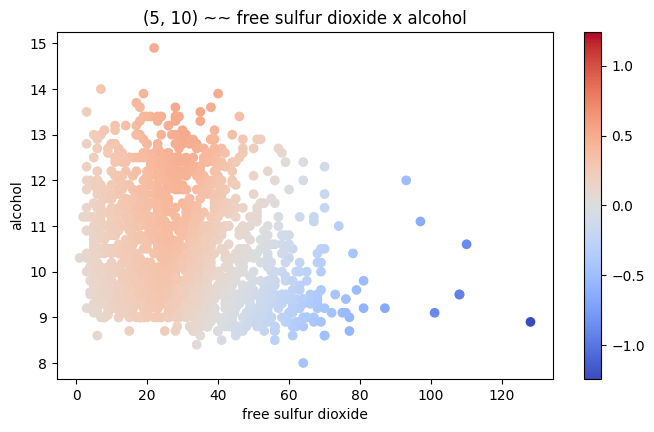

(0, 5)
0.10677264
cc


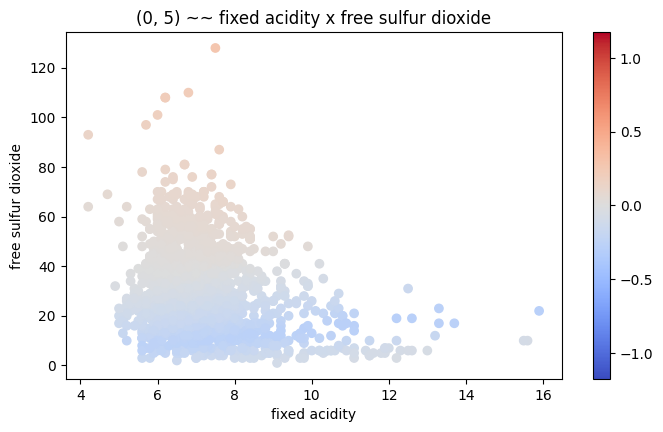

(10,)
0.08263633


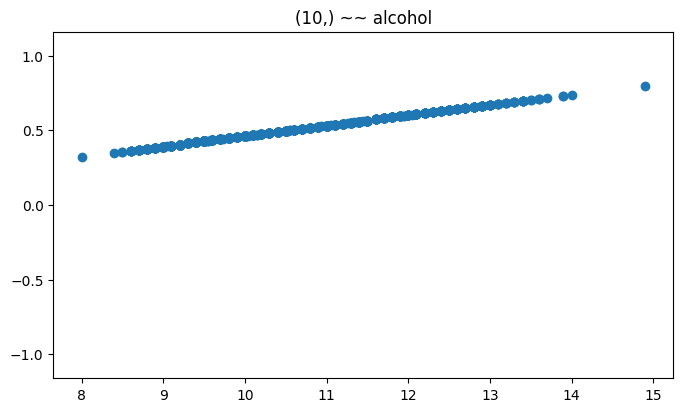

(5,)
0.08225052


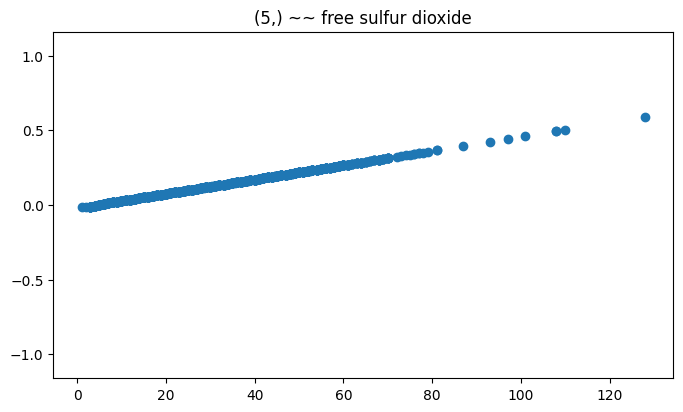

(0,)
0.010827335


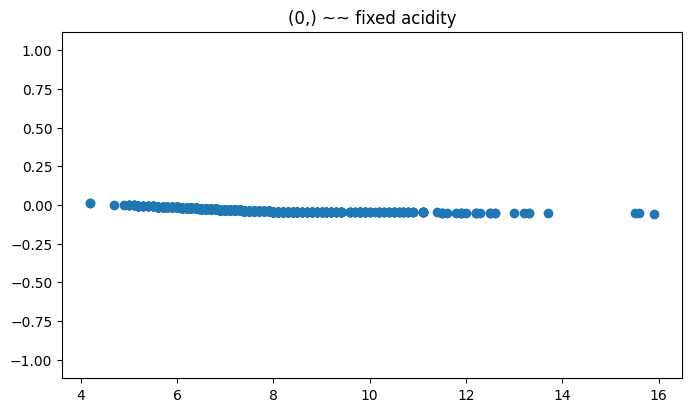

In [14]:
full_readable_labels = dataset_obj.get_full_readable_labels()
plot_all_GAM_functions(trained_sian.cpu(), val_tensor.detach().cpu().numpy(),     full_readable_labels)


In [15]:
pass